## Import necessary libraries

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [286]:
# Load the customer and transaction data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [287]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [288]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


## Pre-processing

In [289]:
# Aggregate the transaction data by CustomerID
transactions_agg = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    transaction_count=('TransactionID', 'count'),
).reset_index()

In [290]:
# Merge the customer and transaction data on 'CustomerID'
data = pd.merge(customers, transactions_agg, on='CustomerID', how='inner')

In [291]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,total_spent,total_quantity,transaction_count
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12,5
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10,4
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14,4
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23,8
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7,3


In [292]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         199 non-null    object 
 1   CustomerName       199 non-null    object 
 2   Region             199 non-null    object 
 3   SignupDate         199 non-null    object 
 4   total_spent        199 non-null    float64
 5   total_quantity     199 non-null    int64  
 6   transaction_count  199 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.0+ KB


In [293]:
data.drop(columns=['CustomerID','CustomerName','SignupDate'],inplace=True)

In [294]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Region'] = le.fit_transform(data['Region'])

In [295]:
data.head()

,Region,total_spent,total_quantity,transaction_count
0,3,3354.52,12,5
1,0,1862.74,10,4
2,3,2725.38,14,4
3,3,5354.88,23,8
4,0,2034.24,7,3


## K-means clustering

In [296]:
# Apply KMeans clustering with a chosen number of clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data)

KMeans(n_clusters=5, random_state=42)

In [297]:
# Get the predicted cluster labels
cluster_labels = kmeans.labels_

In [298]:
# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(data, cluster_labels)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.5253936143438963


In [299]:
# Calculate the Silhouette Score
sil_score = silhouette_score(data, cluster_labels)

# Print the Silhouette Score
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.5366072627362919


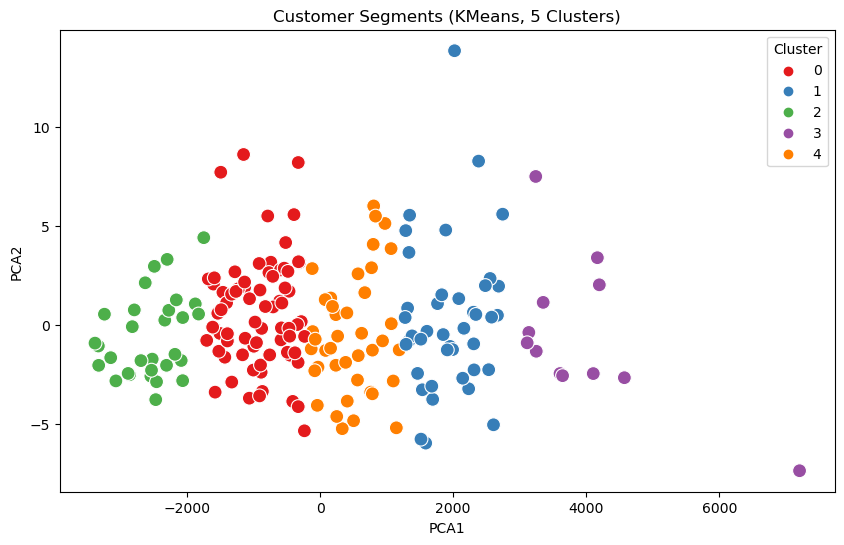

In [300]:
# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data)

# Create a DataFrame for PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='Set1', s=100)
plt.title(f'Customer Segments (KMeans, {n_clusters} Clusters)')
plt.show()

In [301]:
# Loop through different cluster sizes and calculate DB Index
dbi_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    db_index = davies_bouldin_score(data, cluster_labels)
    dbi_scores[k] = db_index

# Display DB Index values for different cluster sizes
for k, dbi in dbi_scores.items():
    print(f'Clusters: {k}, DB Index: {dbi}')

Clusters: 2, DB Index: 0.5504078349032068
Clusters: 3, DB Index: 0.5694192945539948
Clusters: 4, DB Index: 0.5807847268507502
Clusters: 5, DB Index: 0.5253936143438963
Clusters: 6, DB Index: 0.5311599557001995
Clusters: 7, DB Index: 0.44931091072367646
Clusters: 8, DB Index: 0.42845880065253567
Clusters: 9, DB Index: 0.4489206336860277
Clusters: 10, DB Index: 0.4443386226227005


## Agglomerative Clustering

In [302]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [303]:
data.columns = data.columns.astype(str)

In [304]:
# Perform Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_clustering.fit(data)

AgglomerativeClustering(n_clusters=5)

In [305]:
# Get the cluster labels
labels = agg_clustering.labels_

In [306]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(data, labels)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.5348993201630633


In [307]:
# Calculate the Silhouette Score
sil_score = silhouette_score(data, labels)

# Print the Silhouette Score
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.5297845204303645


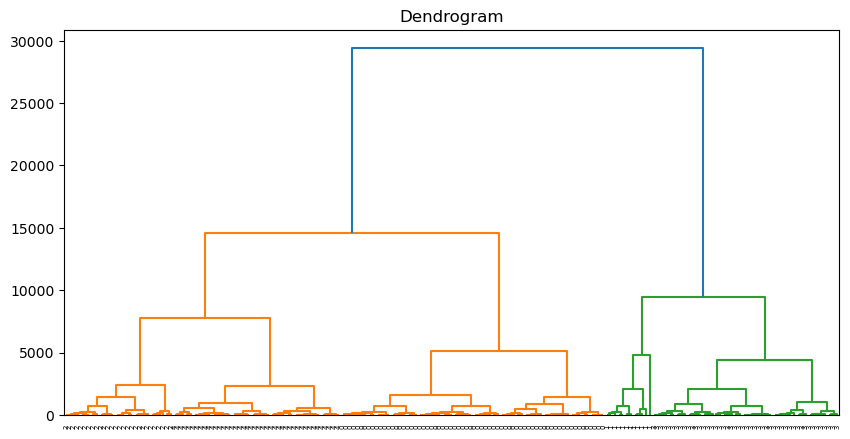

In [308]:
# Create a linkage matrix for dendrogram
linkage_matrix = linkage(data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, orientation='top', labels=labels, distance_sort='descending')
plt.title('Dendrogram')
plt.show()

In [309]:
# Loop through different cluster sizes and calculate DB Index
dbi_scores = {}
for k in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    agg_clustering.fit(data)
    labels = agg_clustering.labels_
    db_index = davies_bouldin_score(data, labels)
    dbi_scores[k] = db_index

# Display DB Index values for different cluster sizes
for k, dbi in dbi_scores.items():
    print(f'Clusters: {k}, DB Index: {dbi}')

Clusters: 2, DB Index: 0.5244036450389459
Clusters: 3, DB Index: 0.5831356951033505
Clusters: 4, DB Index: 0.5825010832318562
Clusters: 5, DB Index: 0.5348993201630633
Clusters: 6, DB Index: 0.5099616478755645
Clusters: 7, DB Index: 0.4363042811199052
Clusters: 8, DB Index: 0.43645086363061436
Clusters: 9, DB Index: 0.4270429606760791
Clusters: 10, DB Index: 0.42199472086507345
